In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from sklearn.cluster import DBSCAN
import cv2 # OpenCV library
import os
from scipy.spatial import KDTree
os.environ['XDG_SESSION_TYPE'] = 'x11'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Data


In [2]:
# Load provided files
intrinsics = np.load("intrinsics.npy")
depth_map = np.load("one-box.depth.npdata.npy")
color_image = np.load("one-box.color.npdata.npy")
extrinsics = np.load("extrinsics.npy")  # Load extrinsics

# Define box corners
# corners = [(603, 433), (430, 675), (663, 853), (833, 610)]

# Normalize and convert to RGB with better contrast
if len(color_image.shape) == 2:
    v_min, v_max = np.percentile(color_image[color_image > 0], [1, 99])
    color_image = np.clip(color_image, v_min, v_max)
    color_image = (color_image - v_min) / (v_max - v_min)
    color_image = np.stack([color_image] * 3, axis=-1)

In [3]:
# Create figure with two subplots side by side
def plot_box():
    plt.figure(figsize=(12, 5))
    
    # Plot depth map with corners
    plt.subplot(1, 2, 1)
    plt.imshow(depth_map, cmap='viridis')
    plt.colorbar(label='Depth (m)')
    plt.title('Depth Map')
    for x, y in corners:
        plt.plot(x, y, 'ro')  # Red dots for corners
    plt.plot([p[0] for p in corners], [p[1] for p in corners], 'r--')  # Connect corners
    
    # Plot color image with corners
    plt.subplot(1, 2, 2)
    plt.imshow(color_image)
    plt.title('Color Image')
    for x, y in corners:
        plt.plot(x, y, 'ro')  # Red dots for corners
    # plt.plot([p[0] for p in corners], [p[1] for p in corners], 'r--')  # Connect corners
    
    plt.tight_layout()
    plt.show()

NameError: name 'corners' is not defined

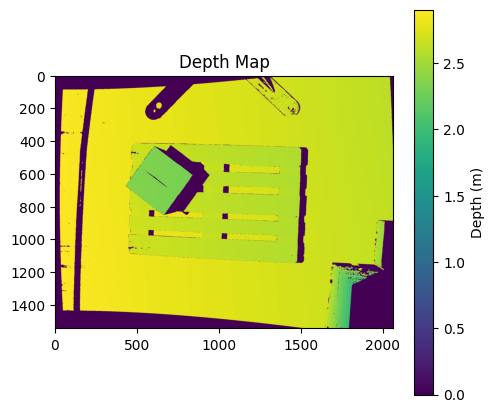

In [4]:
plot_box()

## Filter Out points on Box top by Depth

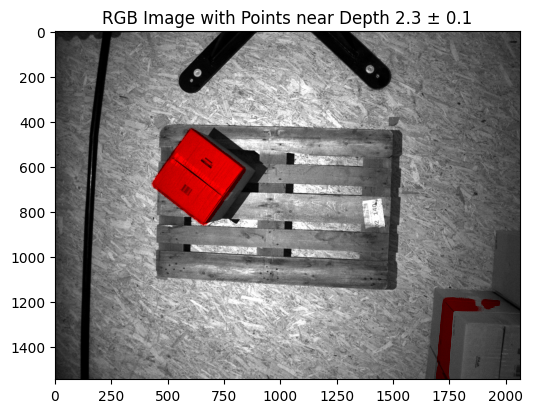

Number of points found: 104241


In [5]:
def check_dist(d, t, c, o):
    # Find points where depth is within threshold t of d
    mask = np.abs(depth_map - d) <= t
    points_y, points_x = np.where(mask)

    # --- NEW: Retrieve the depth values for the identified points ---
    points_depth = depth_map[points_y, points_x]
    # --- END NEW ---

    # Plot RGB image with marked points
    plt.figure(figsize=(6, 6))
    plt.imshow(color_image)
    plt.title(f'RGB Image with Points near Depth {d} ± {t}')
    plt.scatter(points_x, points_y, c=c, alpha=o, s=10)  # Mark points with color c and opacity o
    plt.show()

    # --- UPDATED RETURN: Return points_x, points_y, AND points_depth ---
    return points_x, points_y, points_depth

# Example usage
# This will now return three arrays
points_x, points_y, points_depth = check_dist(2.3, 0.1, 'red', 0.002)

print(f"Number of points found: {len(points_x)}")

In [6]:
# Plot depth map as 2D point cloud
os.environ['XDG_SESSION_TYPE'] = 'x11'
def plot_depth_pointcloud(depth_map, intrinsics):
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape
    u, v = np.meshgrid(np.arange(w), np.arange(h))
    z = depth_map
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy
    points = np.stack([x, y, z], axis=-1).reshape(-1, 3)
    valid = (z > 0).reshape(-1)
    points = points[valid]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd = pcd.voxel_down_sample(voxel_size=0.01)  # Downsample for performance
    o3d.visualization.draw_geometries([pcd], window_name="Depth Map Point Cloud")


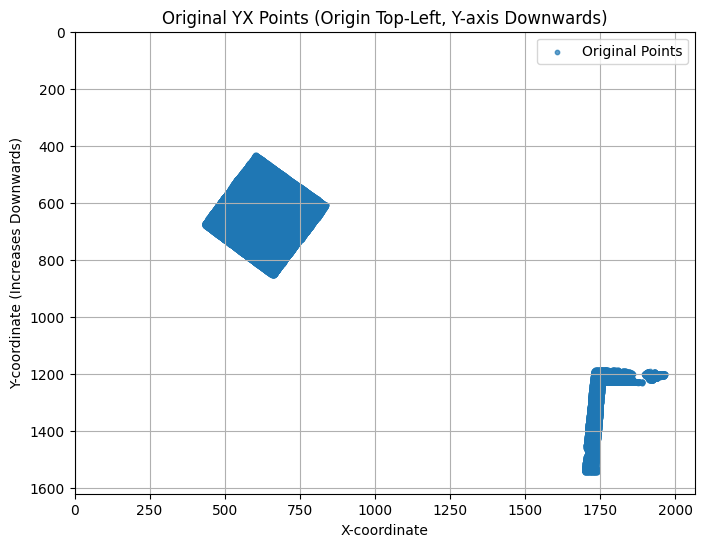

In [7]:
# Assuming points_x and points_y are already defined from your data.
# I will not generate any data here, relying on your environment to have points_x and points_y.

x = points_x
y = points_y
points = np.column_stack((y, x)) # This line is fine for internal data structure

# Visualize the original points
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=10, alpha=0.7, label='Original Points')

# --- Start of adjustments for top-left origin ---
ax = plt.gca() # Get the current axes
ax.invert_yaxis() # Invert the Y-axis so it goes from top (low values) to bottom (high values)

ax.set_xlim(min(0, x.min()), x.max() * 1.05) # Ensure x starts at 0 or below, extends slightly past max
ax.set_ylim(y.max() * 1.05, min(0, y.min())) # Inverted Y: max_y is 'top' value, min_y is 'bottom' value
# --- End of adjustments ---

plt.title('Original YX Points (Origin Top-Left, Y-axis Downwards)')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate (Increases Downwards)') # Clarify label
plt.grid(True)
plt.legend()
plt.show()

## Exclude Outliers: DBScan

Estimated number of clusters: 4
Largest cluster label: 0
Number of points in largest cluster: 87882


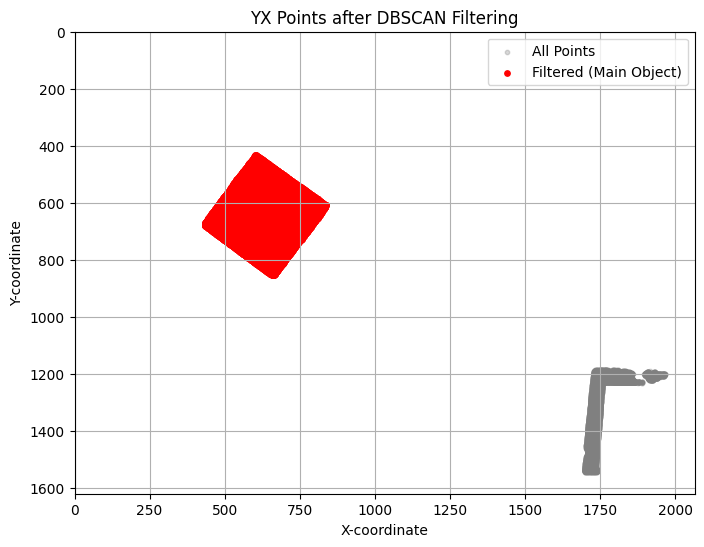

In [8]:


# Assume 'points_x', 'points_y', and 'points_depth' are already defined
# (e.g., from your check_dist function, where points_depth is now returned)

# Combine y, x, and depth into a single array for easier indexing later.
# This array holds ALL the original data for potential filtering.
# Order: [y, x, depth] - choose the order that makes most sense for your indexing later.
all_original_data = np.column_stack((points_y, points_x, points_depth))

# --- DBSCAN Filtering (ONLY uses 2D spatial data) ---
# Create a 2D array for DBSCAN, containing only the (y, x) coordinates.
# DBSCAN will find clusters based on spatial proximity in this 2D plane.
points_for_dbscan = np.column_stack((points_y, points_x))

# Apply DBSCAN
# You'll tune eps and min_samples based on your data's scale and density.
db = DBSCAN(eps=5, min_samples=5).fit(points_for_dbscan)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Estimated number of clusters: {n_clusters_}')

# Find the label of the largest cluster (excluding noise -1)
unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)

if len(unique_labels) > 0:
    largest_cluster_label = unique_labels[np.argmax(counts)]

    # --- Retrieve filtered data including depth ---
    # Apply the labels mask to the 'all_original_data' array,
    # which contains y, x, AND depth.
    filtered_data = all_original_data[labels == largest_cluster_label]

    # Separate filtered y, x, and depth coordinates
    filtered_y = filtered_data[:, 0]
    filtered_x = filtered_data[:, 1]
    filtered_depth = filtered_data[:, 2] # This is your filtered depth information

    print(f'Largest cluster label: {largest_cluster_label}')
    print(f'Number of points in largest cluster: {len(filtered_data)}')

    # --- Visualize the results in 2D (as before) ---
    plt.figure(figsize=(8, 6))
    plt.scatter(points_x, points_y, s=10, alpha=0.3, color='gray', label='All Points')
    plt.scatter(filtered_x, filtered_y, s=15, color='red', label='Filtered (Main Object)')
    plt.title('YX Points after DBSCAN Filtering')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.legend()

    ax = plt.gca()
    ax.invert_yaxis() # Invert the Y-axis for image coordinates

    # Adjust plot limits based on all original points to ensure proper display range
    ax.set_xlim(min(0, points_x.min()), points_x.max() * 1.05)
    ax.set_ylim(points_y.max() * 1.05, min(0, points_y.min()))
    plt.show()

    # Now, filtered_x, filtered_y, and filtered_depth contain the
    # coordinates and depth of the points belonging to the largest detected cluster.
    # You can use filtered_x, filtered_y, filtered_depth for your 3D plotting later.

else:
    print("No clusters found (all points might be outliers with the current DBSCAN parameters).")

## Get Rectangle Points

In [9]:
def get_rectangle_3d_points(filtered_data, color_image=None, plot_2d=True):
    """
    Calculates the 2D minimum area bounding rectangle from filtered points,
    and retrieves corresponding depth values from the filtered_data itself
    using nearest neighbor search.
    Args:
        filtered_data (np.ndarray): A NumPy array of shape (N, 3) where each row
                                    is [y, x, depth] for the points belonging to
                                    the detected object (e.g., from DBSCAN).
        color_image (np.ndarray, optional): The original color image (H, W, 3)
                                            for 2D visualization background. Defaults to None.
        plot_2d (bool, optional): If True, a 2D plot showing the filtered points
                                  and the rectangle with corners/midpoints will be displayed.
                                  Defaults to True.
    Returns:
        tuple: A tuple containing:
            - corners_3d (np.ndarray): (4, 3) array of [x, y, depth] for the rectangle's corners.
            - midpoints_3d (np.ndarray): (4, 3) array of [x, y, depth] for the midpoints of each side.
            - rect_center_3d (np.ndarray): (1, 3) array of [x, y, depth] for the rectangle's center.
            - rect_dims (tuple): (width, height, angle) of the 2D bounding rectangle.
        Returns (None, None, None, None) if not enough points are provided to form a rectangle.
    """
    # Separate y, x, and depth from filtered_data
    filtered_y = filtered_data[:, 0]
    filtered_x = filtered_data[:, 1]
    filtered_depth = filtered_data[:, 2] # We now use this directly!

    # Create a KDTree for efficient nearest neighbor lookup on the filtered (y, x) coordinates
    filtered_spatial_points = np.column_stack((filtered_y, filtered_x))
    kdtree = KDTree(filtered_spatial_points)
    # points_xy is (x, y) for OpenCV minAreaRect
    points_xy_for_min_area_rect = np.column_stack((filtered_x, filtered_y)).astype(np.float32)
    if len(points_xy_for_min_area_rect) < 2:
        print("Not enough points to form a rectangle. Need at least 2 points.")
        return None, None, None, None
    # Calculate the minimum area rotated rectangle
    rect = cv2.minAreaRect(points_xy_for_min_area_rect)
    (center_x_2d, center_y_2d), (width, height), angle = rect
    print(f"Rectangle Center (2D): ({center_x_2d:.2f}, {center_y_2d:.2f})")
    print(f"Rectangle Dimensions (Width, Height): ({width:.2f}, {height:.2f})")
    print(f"Rectangle Angle (degrees): {angle:.2f}")

    # Calculate and print the area
    area = width * height
    print(f"Rectangle Area: {area:.2f}")

    # Get the four corners of the rotated rectangle (x, y) pixel coordinates
    box_2d = cv2.boxPoints(rect)
    corners_2d_float = box_2d # Keep float for precise lookup

    # --- Retrieve Depth Information for Rectangle Points using filtered_data ---
    # Helper to get depth using KDTree for a given (x, y) query point
    def get_depth_from_filtered_data(query_x, query_y):
        query_point_yx = np.array([query_y, query_x]) # KDTree was built on (y, x)
        distance, index = kdtree.query(query_point_yx)

        # Check if the closest point is reasonably close (optional thresholding)
        # If distance > some_threshold, it might mean the queried point is far from any filtered point.
        # For now, we'll just return the depth of the closest point.
        return filtered_depth[index]
    # 1. Get 3D Corners
    corners_3d = []
    print("\nCorner Points (X, Y, Depth):")
    for i, corner_2d in enumerate(corners_2d_float):
        x, y = corner_2d[0], corner_2d[1]
        depth_val = get_depth_from_filtered_data(x, y)
        corners_3d.append([x, y, depth_val])
        print(f"Corner {i+1}: ({x:.2f}, {y:.2f}, Depth: {depth_val:.3f})")
    corners_3d = np.array(corners_3d)
    # 2. Get 3D Midpoints (retained for return value, but not plotted)
    midpoints_2d_float = []
    midpoints_3d = []
    print("\nMidpoints of each side (X, Y, Depth):")
    for i in range(4):
        p1 = corners_2d_float[i]
        p2 = corners_2d_float[(i + 1) % 4]

        mid_x_float = (p1[0] + p2[0]) / 2
        mid_y_float = (p1[1] + p2[1]) / 2
        midpoints_2d_float.append([mid_x_float, mid_y_float])

        depth_val = get_depth_from_filtered_data(mid_x_float, mid_y_float)
        midpoints_3d.append([mid_x_float, mid_y_float, depth_val])
        print(f"Midpoint {i+1}: ({mid_x_float:.2f}, {mid_y_float:.2f}, Depth: {depth_val:.3f})")
    midpoints_2d_float = np.array(midpoints_2d_float)
    midpoints_3d = np.array(midpoints_3d)
    # 3. Get 3D Center
    center_depth_val = get_depth_from_filtered_data(center_x_2d, center_y_2d)
    rect_center_3d = np.array([[center_x_2d, center_y_2d, center_depth_val]])
    print(f"\nRectangle Center (X, Y, Depth): ({rect_center_3d[0,0]:.2f}, {rect_center_3d[0,1]:.2f}, Depth: {rect_center_3d[0,2]:.3f})")
    # --- 2D Visualization ---
    if plot_2d:
        plt.figure(figsize=(10, 8))
        if color_image is not None:
            plt.imshow(color_image)

        plt.scatter(filtered_x, filtered_y, s=10, alpha=0.7, color='blue', label='Filtered Points')

        # Plot the bounding box using float 2D corners for plotting consistency
        plt.plot(corners_2d_float[:, 0], corners_2d_float[:, 1], color='red', linestyle='-', linewidth=2, label='Oriented Bounding Box')
        plt.plot([corners_2d_float[-1, 0], corners_2d_float[0, 0]], [corners_2d_float[-1, 1], corners_2d_float[0, 1]], color='red', linestyle='-', linewidth=2)

        # Plot corners and add coordinates
        plt.scatter(corners_2d_float[:, 0], corners_2d_float[:, 1], s=100, color='purple', marker='o', label='Corner Points')
        for i, (x, y) in enumerate(corners_2d_float):
            plt.text(x + 5, y + 5, f'({x:.0f}, {y:.0f})', color='purple', fontsize=9)

        plt.scatter(center_x_2d, center_y_2d, s=100, color='green', marker='X', label='Rectangle Center')
        plt.text(center_x_2d + 5, center_y_2d + 5, f'Center: ({center_x_2d:.0f}, {center_y_2d:.0f})', color='green', fontsize=9)


        ax = plt.gca()
        ax.invert_yaxis()

        all_x_plot = np.concatenate((filtered_x, corners_2d_float[:,0], [center_x_2d]))
        all_y_plot = np.concatenate((filtered_y, corners_2d_float[:,1], [center_y_2d]))

        ax.set_xlim(min(0, np.min(all_x_plot)-10), np.max(all_x_plot)+10)
        ax.set_ylim(np.max(all_y_plot)+10, min(0, np.min(all_y_plot)-10))
        plt.title('Filtered Points with Bounding Box, Corners, and Center')
        plt.xlabel('X-coordinate')
        plt.ylabel('Y-coordinate (Increases Downwards)')
        plt.grid(True)
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    return corners_3d, midpoints_3d, rect_center_3d, (width, height, angle)


In [34]:
def plot_combined_pointcloud_with_rectangle(depth_map, intrinsics, rectangle_corners_3d, rectangle_midpoints_3d, extrinsics=None):
    """
    Plots the full depth map as a point cloud and overlays the specified rectangle points.

    Args:
        depth_map (np.ndarray): The original full depth map (H, W).
        intrinsics (np.ndarray): The 3x3 camera intrinsic matrix.
        rectangle_corners_3d (np.ndarray): (4, 3) array of [x, y, depth] for the rectangle's corners (pixel coords + depth).
        rectangle_midpoints_3d (np.ndarray): (4, 3) array of [x, y, depth] for the midpoints of each side (pixel coords + depth).
        extrinsics (np.ndarray, optional): A 4x4 extrinsic matrix to transform camera points to world points.
                                          If provided, both the main point cloud and rectangle points will be transformed.
                                          Defaults to None.
    """
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    # --- 1. Create Point Cloud from Full Depth Map ---
    # Use Open3D's built-in conversion for efficiency and robustness
    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))

    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy
    )

    pcd_from_depth = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d,
        o3d_intrinsic,
        depth_scale=1.0, # Adjust if your depth is in mm (e.g., depth_scale=1000.0)
        depth_trunc=4.0  # Max depth to consider, adjust as needed
    )

    # Optional: Downsample for performance (adjust voxel_size as needed)
    pcd_from_depth = pcd_from_depth.voxel_down_sample(voxel_size=0.01)
    pcd_from_depth.paint_uniform_color([0.7, 0.7, 0.7]) # Light gray for general scene

    # --- 2. Convert Rectangle Points to 3D and Create Point Cloud ---
    all_rectangle_2d_with_depth = np.vstack((rectangle_corners_3d, rectangle_midpoints_3d))
    
    rectangle_3d_points = []
    for x_pixel, y_pixel, depth_val in all_rectangle_2d_with_depth:
        if not np.isnan(depth_val) and depth_val > 0: # Ensure valid depth
            # Convert 2D pixel (x_pixel, y_pixel) and depth_val to 3D camera coordinates
            Z_c = depth_val
            X_c = (x_pixel - cx) * Z_c / fx
            Y_c = (y_pixel - cy) * Z_c / fy
            rectangle_3d_points.append([X_c, Y_c, Z_c])
        else:
            print(f"Skipping rectangle point ({x_pixel}, {y_pixel}) due to invalid depth: {depth_val}")

    pcd_rectangle = o3d.geometry.PointCloud()
    if rectangle_3d_points:
        pcd_rectangle.points = o3d.utility.Vector3dVector(np.array(rectangle_3d_points))
        pcd_rectangle.paint_uniform_color([1.0, 0.0, 0.0]) # Red color for rectangle points
        pcd_rectangle.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
        # pcd_rectangle.orient_normals_to_camera_location() # Optional: Orient normals for consistent lighting

    # --- Apply Extrinsics (if provided) ---
    if extrinsics is not None:
        pcd_from_depth.transform(extrinsics)
        if rectangle_3d_points: # Only transform if there are valid rectangle points
            # Manually transform rectangle points from camera to world coordinates
            transformed_rect_points = []
            for pt_cam in rectangle_3d_points:
                point_cam_h = np.array([pt_cam[0], pt_cam[1], pt_cam[2], 1.0])
                point_world_h = extrinsics @ point_cam_h
                transformed_rect_points.append(point_world_h[:3].tolist())
            pcd_rectangle.points = o3d.utility.Vector3dVector(np.array(transformed_rect_points))
            
    # --- 3. Combine and Visualize ---
    geometries_to_plot = [pcd_from_depth]
    if rectangle_3d_points:
        geometries_to_plot.append(pcd_rectangle)
    
    o3d.visualization.draw_geometries(geometries_to_plot, window_name="Combined Point Cloud with Rectangle")


# --- How to use it with your data ---

# Assume these variables are defined from your previous steps:
# intrinsics = np.load("intrinsics.npy")
# depth_map = np.load("one-box.depth.npdata.npy")
# color_image = np.load("one-box.color.npdata.npy") # Not used in this specific plot, but good to have
# extrinsics = np.load("extrinsics.npy")

# Your rectangle data (from your output, converted to NumPy arrays if not already)
# Ensure these are float types if they aren't already for calculations
corners_data = np.array([
    [421, 679, 2.356],
    [603, 432, 2.337],
    [843, 608, 2.317], # This depth 0.000 will be skipped. Ensure valid depths.
    [661, 855, 2.341]
], dtype=np.float32)

midpoints_data = np.array([
    [512.00, 555.50, 2.347],
    [723.00, 520.00, 2.324], # This depth 0.000 will be skipped.
    [752.00, 731.50, 2.326], # This depth 0.000 will be skipped.
    [541.00, 767.00, 2.348]
], dtype=np.float32)

# Call the new function
plot_combined_pointcloud_with_rectangle(
    depth_map=depth_map,
    intrinsics=intrinsics,
    rectangle_corners_3d=corners_data,
    rectangle_midpoints_3d=midpoints_data,
    extrinsics=extrinsics # Pass your extrinsics here if you want world coordinates
)

Rectangle Center (2D): (632.48, 644.07)
Rectangle Dimensions (Width, Height): (298.35, 306.70)
Rectangle Angle (degrees): 36.31
Rectangle Area: 91506.66

Corner Points (X, Y, Depth):
Corner 1: (421.46, 679.30, Depth: 2.356)
Corner 2: (603.09, 432.16, Depth: 2.337)
Corner 3: (843.50, 608.85, Depth: 2.317)
Corner 4: (661.87, 855.99, Depth: 2.341)

Midpoints of each side (X, Y, Depth):
Midpoint 1: (512.27, 555.73, Depth: 2.347)
Midpoint 2: (723.29, 520.50, Depth: 2.324)
Midpoint 3: (752.68, 732.42, Depth: 2.326)
Midpoint 4: (541.66, 767.64, Depth: 2.348)

Rectangle Center (X, Y, Depth): (632.48, 644.07, Depth: 2.333)


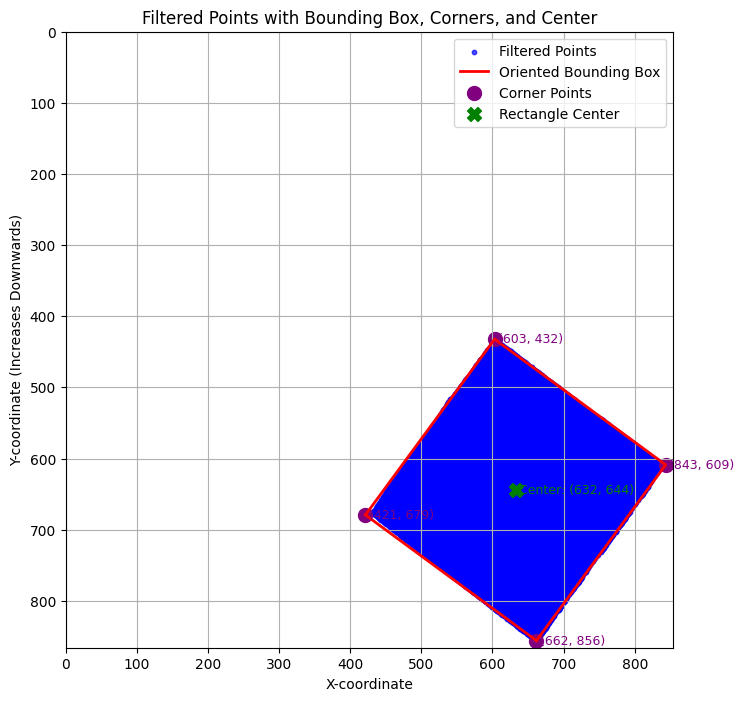

(array([[421.45535278, 679.29864502,   2.35619187],
        [603.08703613, 432.16033936,   2.33706594],
        [843.49768066, 608.84759521,   2.31714606],
        [661.8659668 , 855.98590088,   2.34085774]]),
 array([[512.2711792 , 555.72949219,   2.34738326],
        [723.2923584 , 520.50396729,   2.32409644],
        [752.68182373, 732.41674805,   2.32580352],
        [541.66064453, 767.64227295,   2.34803033]]),
 array([[632.47650146, 644.07312012,   2.33296633]]),
 (298.3548889160156, 306.7040710449219, 36.31364059448242))

In [10]:
get_rectangle_3d_points(filtered_data)

In [11]:
def select_nearest_cluster(depth_map, intrinsics, eps=0.05, min_points=20):
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx, fy, cx, cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=1000.0, depth_trunc=4000.0
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)

    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points))
    if labels.max() < 0:
        raise ValueError("No clusters found")

    points = np.asarray(pcd.points)

    mean_z_per_cluster = {
        label: np.mean(points[labels == label][:, 2])
        for label in np.unique(labels)
        if label != -1
    }

    selected_label = min(mean_z_per_cluster, key=mean_z_per_cluster.get)
    selected_points = points[labels == selected_label]
    mean_z = mean_z_per_cluster[selected_label]

    return selected_points, mean_z

def filter_cluster_to_depth_coords(cluster_points, mean_z, intrinsics, z_threshold=0.01):
    """
    Filters 3D cluster points near mean_z and converts to (x, y) image coordinates.
    Returns: np.ndarray of shape (N, 3) → [x_pixel, y_pixel, z]
    """
    # 1. Filter by Z threshold
    close_mask = np.abs(cluster_points[:, 2] - mean_z) < z_threshold
    filtered_points = cluster_points[close_mask]

    if len(filtered_points) == 0:
        return np.empty((0, 3))

    # 2. Project to 2D using intrinsics
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    x, y, z = filtered_points[:, 0], filtered_points[:, 1], filtered_points[:, 2]
    u = (fx * x / z + cx).astype(int)
    v = (fy * y / z + cy).astype(int)

    # 3. Stack and return
    return np.stack([u, v, z], axis=1)


In [12]:
cluster_points, mean_z = select_nearest_cluster(depth_map, intrinsics, eps=0.05, min_points=20)
box_uvz = filter_cluster_to_depth_coords(cluster_points, mean_z, intrinsics, z_threshold=0.1)

Rectangle Center (2D): (643.65, 631.53)
Rectangle Dimensions (Width, Height): (297.05, 304.34)
Rectangle Angle (degrees): 53.47
Rectangle Area: 90403.64

Corner Points (X, Y, Depth):
Corner 1: (432.97, 602.76, Depth: 2.337)
Corner 2: (677.53, 421.61, Depth: 2.356)
Corner 3: (854.34, 660.31, Depth: 2.340)
Corner 4: (609.78, 841.46, Depth: 2.313)

Midpoints of each side (X, Y, Depth):
Midpoint 1: (555.25, 512.19, Depth: 2.344)
Midpoint 2: (765.93, 540.96, Depth: 2.347)
Midpoint 3: (732.06, 750.88, Depth: 2.323)
Midpoint 4: (521.38, 722.11, Depth: 2.324)

Rectangle Center (X, Y, Depth): (643.65, 631.53, Depth: 2.334)


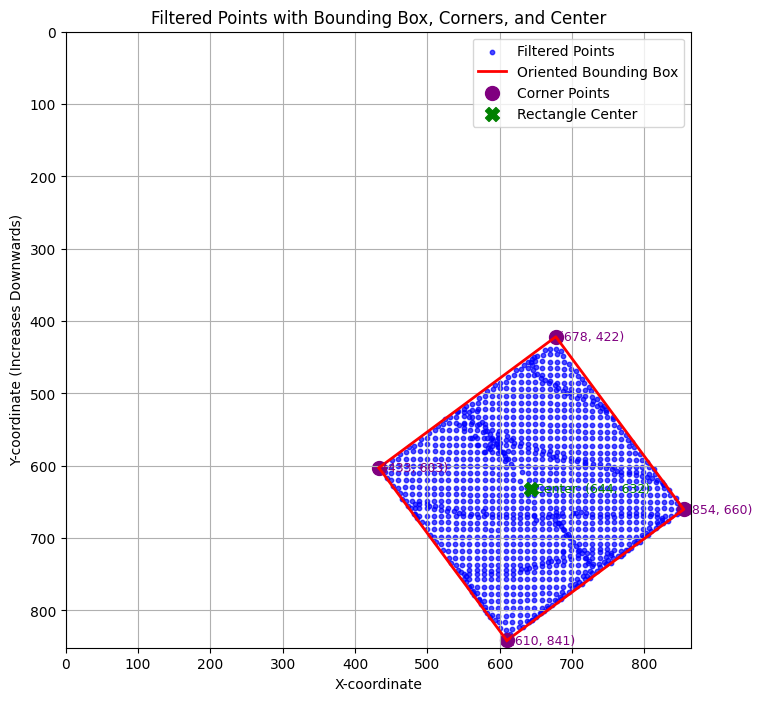

In [13]:
rectangle_cp = get_rectangle_3d_points(box_uvz)

Selected cluster: Label 3, Mean Z 2.3327 m, Points 1206
Rectangle Center (2D): (632.23, 644.11)
Rectangle Dimensions (Width, Height): (297.28, 303.65)
Rectangle Angle (degrees): 36.70
Rectangle Area: 90268.90
[[422.318   676.99585]
 [603.80505 433.54468]
 [842.1416  611.219  ]
 [660.65454 854.67017]]


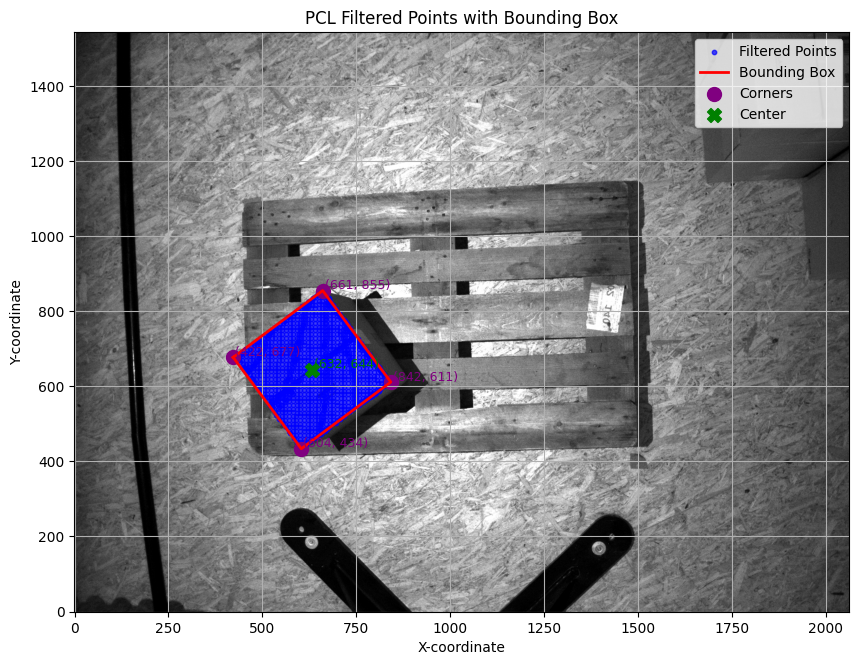

In [14]:

def select_nearest_cluster(depth_map, intrinsics, eps=0.05, min_points=20):
    """
    Select the cluster with the lowest mean z-value (closest to camera).
    
    Args:
        depth_map (np.ndarray): Depth map (H, W).
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        eps (float): DBSCAN clustering distance (default 0.05).
        min_points (int): Minimum points per cluster (default 20).
    
    Returns:
        np.ndarray: (N, 3) array of 3D points for the selected cluster.
        float: Mean z-value of the selected cluster.
        int: Selected cluster label.
    """
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx, fy, cx, cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=1000.0, depth_trunc=4000.0
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)

    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points))
    if labels.max() < 0:
        raise ValueError("No clusters found")

    points = np.asarray(pcd.points)
    mean_z_per_cluster = {
        label: np.mean(points[labels == label][:, 2])
        for label in np.unique(labels) if label != -1
    }

    selected_label = min(mean_z_per_cluster, key=mean_z_per_cluster.get)
    selected_points = points[labels == selected_label]
    mean_z = mean_z_per_cluster[selected_label]

    print(f"Selected cluster: Label {selected_label}, Mean Z {mean_z:.4f} m, Points {len(selected_points)}")
    return selected_points, mean_z, selected_label

def filter_cluster_to_depth_coords(cluster_points, mean_z, intrinsics, z_threshold=0.1):

    close_mask = np.abs(cluster_points[:, 2] - mean_z) < z_threshold
    filtered_points = cluster_points[close_mask]

    if len(filtered_points) == 0:
        return np.empty((0, 3))

    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    x, y, z = filtered_points[:, 0], filtered_points[:, 1], filtered_points[:, 2]
    u = (fx * x / z + cx).astype(float)
    v = (fy * y / z + cy).astype(float)
    return np.stack([u, v, z], axis=1)

def get_rectangle_3d_points_pcl(filtered_data, color_image=None, extrinsics=None, plot_2d=True):
    """
    Calculates the 2D minimum area bounding rectangle from filtered points and maps to 3D.
    
    Args:
        filtered_data (np.ndarray): (N, 3) array of [x_pixel, y_pixel, z].
        color_image (np.ndarray, optional): Color image (H, W, 3) for visualization.
        extrinsics (np.ndarray, optional): 4x4 camera to world extrinsic matrix.
        plot_2d (bool): If True, plots the 2D rectangle and points.
    
    Returns:
        tuple: (corners_3d, midpoints_3d, rect_center_3d, (width, height, angle))
    """
    filtered_x, filtered_y, filtered_z = filtered_data[:, 0], filtered_data[:, 1], filtered_data[:, 2]
    points_xy = np.column_stack((filtered_x, filtered_y)).astype(np.float32)

    if len(points_xy) < 2:
        print("Not enough points to form a rectangle.")
        return None, None, None, None

    rect = cv2.minAreaRect(points_xy)
    (center_x_2d, center_y_2d), (width, height), angle = rect
    area = width * height
    print(f"Rectangle Center (2D): ({center_x_2d:.2f}, {center_y_2d:.2f})")
    print(f"Rectangle Dimensions (Width, Height): ({width:.2f}, {height:.2f})")
    print(f"Rectangle Angle (degrees): {angle:.2f}")
    print(f"Rectangle Area: {area:.2f}")

    box_2d = cv2.boxPoints(rect)
    kdtree = KDTree(points_xy)
    corners_3d = []
    for corner_2d in box_2d:
        _, idx = kdtree.query(corner_2d.reshape(1, -1))
        corner_3d = filtered_data[idx[0]]
        corners_3d.append(corner_3d)
    corners_3d = np.array(corners_3d)

    midpoints_2d = [(box_2d[i] + box_2d[(i + 1) % 4]) / 2 for i in range(4)]
    midpoints_3d = []
    for mid_2d in midpoints_2d:
        _, idx = kdtree.query(mid_2d.reshape(1, -1))
        mid_3d = filtered_data[idx[0]]
        midpoints_3d.append(mid_3d)
    midpoints_3d = np.array(midpoints_3d)

    _, idx = kdtree.query(np.array([center_x_2d, center_y_2d]).reshape(1, -1))
    rect_center_3d = filtered_data[idx[0]].reshape(1, -1)

    print(box_2d)
    if plot_2d:
        plt.figure(figsize=(10, 8))
        if color_image is not None:
            plt.imshow(color_image)
        plt.scatter(filtered_x, filtered_y, s=10, alpha=0.7, color='blue', label='Filtered Points')
        plt.plot(np.append(box_2d[:, 0], box_2d[0, 0]), np.append(box_2d[:, 1], box_2d[0, 1]), 
                color='red', linestyle='-', linewidth=2, label='Bounding Box')
        plt.scatter(box_2d[:, 0], box_2d[:, 1], s=100, color='purple', marker='o', label='Corners')
        plt.scatter(center_x_2d, center_y_2d, s=100, color='green', marker='X', label='Center')
        for i, (x, y) in enumerate(box_2d):
            plt.text(x + 5, y + 5, f'({x:.0f}, {y:.0f})', color='purple', fontsize=9)
        plt.text(center_x_2d + 5, center_y_2d + 5, f'({center_x_2d:.0f}, {center_y_2d:.0f})', 
                color='green', fontsize=9)
        plt.gca().invert_yaxis()
        plt.title('PCL Filtered Points with Bounding Box')
        plt.xlabel('X-coordinate')
        plt.ylabel('Y-coordinate')
        plt.grid(True)
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    if extrinsics is not None:
        points_hom = np.hstack((corners_3d[:, :3], np.ones((len(corners_3d), 1))))
        corners_3d = (points_hom @ extrinsics.T)[:, :3]
        points_hom = np.hstack((midpoints_3d[:, :3], np.ones((len(midpoints_3d), 1))))
        midpoints_3d = (points_hom @ extrinsics.T)[:, :3]
        points_hom = np.hstack((rect_center_3d[:, :3], np.ones((1, 1))))
        rect_center_3d = (points_hom @ extrinsics.T)[:, :3]

    return corners_3d, midpoints_3d, rect_center_3d, (width, height, angle)


# PCL approach
cluster_points, mean_z, selected_label = select_nearest_cluster(depth_map, intrinsics)
filtered_data = filter_cluster_to_depth_coords(cluster_points, mean_z, intrinsics)
corners_3d, midpoints_3d, rect_center_3d, rect_dims = get_rectangle_3d_points_pcl(
    filtered_data, color_image=color_image, extrinsics=extrinsics
)

In [116]:
def calculate_box_height(box_point_2d, box_depth, plane_point_2d, plane_depth, intrinsics, extrinsics):
    """
    More robust method: computes height in world coordinates.
    """
    def pixel_to_camera(x, y, depth, K):
        fx, fy = K[0, 0], K[1, 1]
        cx, cy = K[0, 2], K[1, 2]
        X = (x - cx) * depth / fx
        Y = (y - cy) * depth / fy
        Z = depth
        return np.array([X, Y, Z])

    def camera_to_world(pt_cam, extrinsics):
        pt_cam_h = np.append(pt_cam, 1.0)  # to homogeneous
        pt_world_h = extrinsics @ pt_cam_h
        return pt_world_h[:3]

    # Convert both points
    pt_box_cam = pixel_to_camera(*box_point_2d, box_depth, intrinsics)
    pt_plane_cam = pixel_to_camera(*plane_point_2d, plane_depth, intrinsics)

    pt_box_world = camera_to_world(pt_box_cam, extrinsics)
    pt_plane_world = camera_to_world(pt_plane_cam, extrinsics)

    # Get world vertical (assume Z-up in world frame)
    height = pt_plane_world[2] - pt_box_world[2]  # Z-world difference

    return height


Depth map shape: (1544, 2064), min: 0.0000, max: 2.9041
Selected cluster: Label 3, Mean Z 2.3327 m, Points 1206
Rectangle Center (2D): (632.23, 644.11)
Rectangle Dimensions (Width, Height): (297.28, 303.65)
Rectangle Angle (degrees): 36.70
Rectangle Area: 90268.90
2D corners with depth:
[[[602.99974389 434.62495485   2.33650306]]

 [[834.41708736 609.79188424   2.31349824]]

 [[661.50005501 853.           2.34036613]]

 [[438.69687305 678.43953324   2.35630706]]]


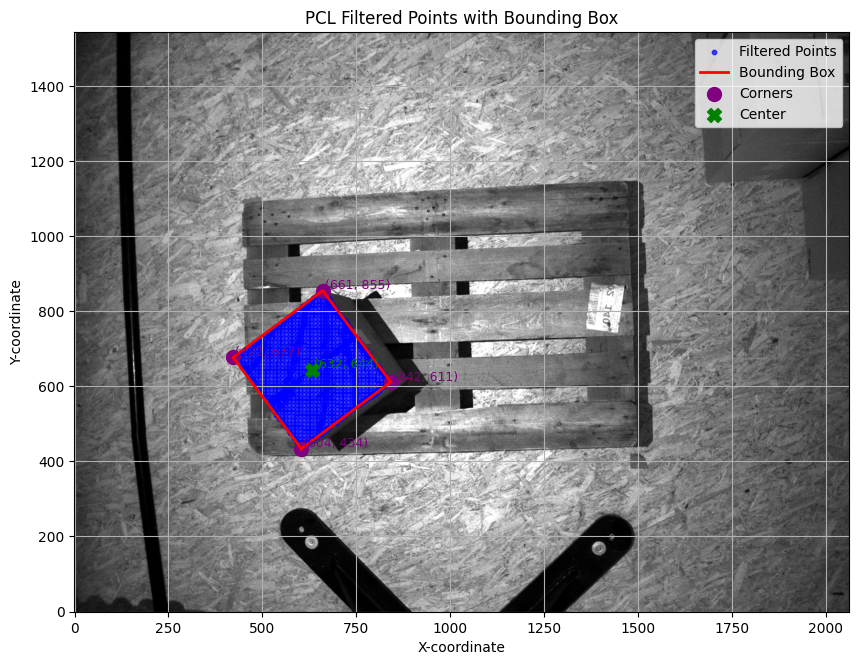

ValueError: Expected 4 corners with [pixel_x, pixel_y, depth], got shape (4, 1, 3)

In [15]:
import numpy as np
import open3d as o3d
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

def select_nearest_cluster(depth_map, intrinsics, eps=0.05, min_points=20, depth_scale=1.0):
    """
    Select the cluster with the lowest mean z-value (closest to camera).
    
    Args:
        depth_map (np.ndarray): Depth map (H, W).
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        eps (float): DBSCAN clustering distance (default 0.05).
        min_points (int): Minimum points per cluster (default 20).
        depth_scale (float): Depth map scale (default 1.0 for meters).
    
    Returns:
        np.ndarray: (N, 3) array of 3D points for the selected cluster.
        float: Mean z-value of the selected cluster.
        int: Selected cluster label.
    """
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    print(f"Depth map shape: {depth_map.shape}, min: {depth_map.min():.4f}, max: {depth_map.max():.4f}")

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx, fy, cx, cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=depth_scale, depth_trunc=4.0
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)

    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points))
    if labels.max() < 0:
        raise ValueError("No clusters found")

    points = np.asarray(pcd.points)
    mean_z_per_cluster = {
        label: np.mean(points[labels == label][:, 2])
        for label in np.unique(labels) if label != -1
    }

    selected_label = min(mean_z_per_cluster, key=mean_z_per_cluster.get)
    selected_points = points[labels == selected_label]
    mean_z = mean_z_per_cluster[selected_label]

    print(f"Selected cluster: Label {selected_label}, Mean Z {mean_z:.4f} m, Points {len(selected_points)}")
    return selected_points, mean_z, selected_label

def filter_cluster_to_depth_coords(cluster_points, mean_z, intrinsics, z_threshold=0.1):
    """
    Filters 3D cluster points near mean_z and converts to [u, v, z] image coordinates.
    
    Args:
        cluster_points (np.ndarray): (N, 3) array of 3D points.
        mean_z (float): Mean z-value of the cluster.
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        z_threshold (float): Z-value threshold for filtering (default 0.1).
    
    Returns:
        np.ndarray: (N, 3) array of [x_pixel, y_pixel, z].
    """
    close_mask = np.abs(cluster_points[:, 2] - mean_z) < z_threshold
    filtered_points = cluster_points[close_mask]

    if len(filtered_points) == 0:
        return np.empty((0, 3))

    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    x, y, z = filtered_points[:, 0], filtered_points[:, 1], filtered_points[:, 2]
    u = (fx * x / z + cx).astype(float)
    v = (fy * y / z + cy).astype(float)
    return np.stack([u, v, z], axis=1)

def sort_corners_clockwise_2d(corners_2d):
    """
    Sort 2D corners clockwise around their centroid.

    Args:
        corners_2d (np.ndarray): (4, 2) array of [pixel_x, pixel_y].

    Returns:
        np.ndarray: Indices sorting corners clockwise.
    """
    centroid = np.mean(corners_2d, axis=0)
    angles = np.arctan2(corners_2d[:, 1] - centroid[1], corners_2d[:, 0] - centroid[0])
    return np.argsort(angles)

def get_rectangle_2d_depth_points_pcl(filtered_data, color_image=None, plot_2d=True):
    """
    Calculate 2D minimum area bounding rectangle and return corners with depth.

    Args:
        filtered_data (np.ndarray): (N, 3) array of [x_pixel, y_pixel, z].
        color_image (np.ndarray, optional): Color image (H, W, 3) for visualization.
        plot_2d (bool): If True, plots the 2D rectangle and points.

    Returns:
        np.ndarray: (4, 3) array of [x_pixel, y_pixel, z] for rectangle corners.
    """
    filtered_x, filtered_y, filtered_z = filtered_data[:, 0], filtered_data[:, 1], filtered_data[:, 2]
    points_xy = np.column_stack((filtered_x, filtered_y)).astype(np.float32)

    if len(points_xy) < 2:
        print("Not enough points to form a rectangle.")
        return np.empty((0, 3))

    rect = cv2.minAreaRect(points_xy)
    (center_x_2d, center_y_2d), (width, height), angle = rect
    area = width * height
    print(f"Rectangle Center (2D): ({center_x_2d:.2f}, {center_y_2d:.2f})")
    print(f"Rectangle Dimensions (Width, Height): ({width:.2f}, {height:.2f})")
    print(f"Rectangle Angle (degrees): {angle:.2f}")
    print(f"Rectangle Area: {area:.2f}")

    box_2d = cv2.boxPoints(rect)
    sorted_indices = sort_corners_clockwise_2d(box_2d)
    box_2d = box_2d[sorted_indices]

    kdtree = KDTree(points_xy)
    corners_2d_depth = []
    for corner_2d in box_2d:
        _, idx = kdtree.query(corner_2d.reshape(1, -1))
        corner_data = filtered_data[idx[0]]  # [u, v, z]
        corners_2d_depth.append(corner_data)
    corners_2d_depth = np.array(corners_2d_depth)
    print(f"2D corners with depth:\n{corners_2d_depth}")

    if plot_2d:
        plt.figure(figsize=(10, 8))
        if color_image is not None:
            plt.imshow(color_image)
        plt.scatter(filtered_x, filtered_y, s=10, alpha=0.7, color='blue', label='Filtered Points')
        plt.plot(np.append(box_2d[:, 0], box_2d[0, 0]), np.append(box_2d[:, 1], box_2d[0, 1]), 
                color='red', linestyle='-', linewidth=2, label='Bounding Box')
        plt.scatter(box_2d[:, 0], box_2d[:, 1], s=100, color='purple', marker='o', label='Corners')
        plt.scatter(center_x_2d, center_y_2d, s=100, color='green', marker='X', label='Center')
        for i, (x, y) in enumerate(box_2d):
            plt.text(x + 5, y + 5, f'({x:.0f}, {y:.0f})', color='purple', fontsize=9)
        plt.text(center_x_2d + 5, center_y_2d + 5, f'({center_x_2d:.0f}, {center_y_2d:.0f})', 
                color='green', fontsize=9)
        plt.gca().invert_yaxis()
        plt.title('PCL Filtered Points with Bounding Box')
        plt.xlabel('X-coordinate')
        plt.ylabel('Y-coordinate')
        plt.grid(True)
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    return corners_2d_depth

def estimate_box_pose(top_corners_2d_depth, intrinsics, box_size=0.3):
    """
    Estimate 4x4 transformation matrix (camera to object frame) for a box.

    Args:
        top_corners_2d_depth (np.ndarray): (4, 3) array of [pixel_x, pixel_y, depth].
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        box_size (float): Size of the cube (default 0.3m).

    Returns:
        np.ndarray: 4x4 transformation matrix (camera to object frame).
    """
    if top_corners_2d_depth.shape != (4, 3):
        raise ValueError(f"Expected 4 corners with [pixel_x, pixel_y, depth], got shape {top_corners_2d_depth.shape}")
    print(f"Input corners_2d_depth:\n{top_corners_2d_depth}")

    # Project to 3D camera coordinates
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    top_corners_camera = np.zeros((4, 3))
    for i in range(4):
        u, v, depth = top_corners_2d_depth[i]
        if depth <= 0:
            raise ValueError(f"Invalid depth value {depth} for corner {i}")
        x = (u - cx) * depth / fx
        y = (v - cy) * depth / fy
        z = depth
        top_corners_camera[i] = [x, y, z]
    print(f"3D corners (camera frame):\n{top_corners_camera}")

    # Define box corners in object frame
    half_size = box_size / 2
    corners_object = np.array([
        [-half_size, -half_size, -half_size],  # Corner 0
        [ half_size, -half_size, -half_size],  # Corner 1
        [ half_size,  half_size, -half_size],  # Corner 2
        [-half_size,  half_size, -half_size]   # Corner 3
    ])

    # Debug: Compute 2D angles to verify ordering
    corners_2d = top_corners_2d_depth[:, :2]
    centroid_2d = np.mean(corners_2d, axis=0)
    angles_2d = np.arctan2(corners_2d[:, 1] - centroid_2d[1], corners_2d[:, 0] - centroid_2d[0]) * 180 / np.pi
    print(f"2D corner angles (degrees):\n{angles_2d}")

    # Debug: Compute 3D angles in XY plane
    centroid_camera = np.mean(top_corners_camera, axis=0)
    angles_3d = np.arctan2(top_corners_camera[:, 1] - centroid_camera[1], 
                          top_corners_camera[:, 0] - centroid_camera[0]) * 180 / np.pi
    print(f"3D corner angles (XY plane, degrees):\n{angles_3d}")

    # Kabsch algorithm
    center_object = np.mean(corners_object, axis=0)
    center_camera = np.mean(top_corners_camera, axis=0)
    centered_object = corners_object - center_object
    centered_camera = top_corners_camera - center_camera

    H = centered_camera.T @ centered_object
    U, _, Vt = np.linalg.svd(H)
    rotation = Vt.T @ U.T
    if np.linalg.det(rotation) < 0:
        Vt[2, :] *= -1
        rotation = Vt.T @ U.T
    print(f"Rotation matrix (det: {np.linalg.det(rotation):.4f}):\n{rotation}")

    # Check rotation angle in XY plane
    angle_xy = np.arctan2(rotation[1, 0], rotation[0, 0]) * 180 / np.pi
    print(f"Estimated rotation angle in XY plane (degrees): {angle_xy:.2f}")

    # Adjust rotation if deviation is ~17°
    expected_angle = angle_xy - 17.0  # Subtract measured deviation
    adjust_angle = np.deg2rad(17.0)
    adjust_rotation = np.array([
        [np.cos(adjust_angle), -np.sin(adjust_angle), 0],
        [np.sin(adjust_angle),  np.cos(adjust_angle), 0],
        [0,                    0,                    1]
    ])
    rotation = rotation @ adjust_rotation
    print(f"Adjusted rotation matrix (det: {np.linalg.det(rotation):.4f}):\n{rotation}")
    print(f"Adjusted rotation angle in XY plane (degrees): {np.arctan2(rotation[1, 0], rotation[0, 0]) * 180 / np.pi:.2f}")

    translation = center_camera - rotation @ center_object
    print(f"Translation vector:\n{translation}")

    T_camera_object = np.eye(4)
    T_camera_object[:3, :3] = rotation
    T_camera_object[:3, 3] = translation

    return T_camera_object

def plot_pointcloud_with_red_cube(depth_map, intrinsics, extrinsics, T_camera_object, box_size=0.3, depth_scale=1.0):
    """
    Visualize depth map as a z-colored point cloud with a 0.3m red cube.

    Args:
        depth_map (np.ndarray): Depth map (H, W).
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        extrinsics (np.ndarray): 4x4 camera to world extrinsic matrix.
        T_camera_object (np.ndarray): 4x4 transformation matrix (camera to object frame).
        box_size (float): Size of the cube (default 0.3m).
        depth_scale (float): Depth map scale (default 1.0 for meters).

    Returns:
        None: Displays the visualization.
    """
    print(f"Depth map shape: {depth_map.shape}, min: {depth_map.min():.4f}, max: {depth_map.max():.4f}")
    print(f"T_camera_object:\n{T_camera_object}")

    # Create point cloud
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=depth_scale, depth_trunc=4.0
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)
    points = np.asarray(pcd.points)
    if len(points) == 0:
        raise ValueError("Point cloud is empty. Check depth_map, intrinsics, or depth_scale.")
    print(f"Point cloud points: {len(points)}, min z: {points[:, 2].min():.4f}, max z: {points[:, 2].max():.4f}")

    # Color points based on z-value
    z_values = points[:, 2]
    z_min, z_max = z_values.min(), z_values.max()
    print(f"Z-value range for coloring: min {z_min:.4f}, max {z_max:.4f}")
    z_normalized = (z_values - z_min) / (z_max - z_min + 1e-6)
    colormap = plt.get_cmap("viridis")
    colors = colormap(z_normalized)[:, :3]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    pcd.transform(extrinsics)

    # Create cube mesh
    half_size = box_size / 2
    vertices_obj = np.array([
        [-half_size, -half_size, -half_size], [ half_size, -half_size, -half_size],
        [ half_size,  half_size, -half_size], [-half_size,  half_size, -half_size],
        [-half_size, -half_size,  half_size], [ half_size, -half_size,  half_size],
        [ half_size,  half_size,  half_size], [-half_size,  half_size,  half_size]
    ])
    vertices_hom = np.hstack((vertices_obj, np.ones((8, 1))))
    vertices_camera = (vertices_hom @ T_camera_object.T)[:, :3]
    vertices_world = vertices_camera @ extrinsics[:3, :3].T + extrinsics[:3, 3]
    print(f"Cube vertices (world frame):\n{vertices_world}")

    triangles = o3d.utility.Vector3iVector([
        [0, 1, 2], [0, 2, 3], [4, 5, 6], [4, 6, 7],
        [0, 4, 5], [0, 5, 1], [1, 5, 6], [1, 6, 2],
        [2, 6, 7], [2, 7, 3], [3, 7, 4], [3, 4, 0]
    ])
    box_mesh = o3d.geometry.TriangleMesh(
        vertices=o3d.utility.Vector3dVector(vertices_world),
        triangles=triangles
    )
    box_mesh.paint_uniform_color([1.0, 0.0, 0.0])  # Red for cube
    box_mesh.compute_vertex_normals()

    # Visualize
    o3d.visualization.draw_geometries([pcd, box_mesh], window_name="Point Cloud with Red Cube")

# --- Usage ---
intrinsics = np.load("intrinsics.npy")
depth_map = np.load("one-box.depth.npdata.npy")
extrinsics = np.load("extrinsics.npy")
color_image = np.load("one-box.color.npdata.npy")  # Optional

# Normalize and convert to RGB with better contrast
if len(color_image.shape) == 2:
    v_min, v_max = np.percentile(color_image[color_image > 0], [1, 99])
    color_image = np.clip(color_image, v_min, v_max)
    color_image = (color_image - v_min) / (v_max - v_min)
    color_image = np.stack([color_image] * 3, axis=-1)
    
# PCL approach
cluster_points, mean_z, selected_label = select_nearest_cluster(depth_map, intrinsics, depth_scale=1.0)
filtered_data = filter_cluster_to_depth_coords(cluster_points, mean_z, intrinsics, z_threshold=0.1)
top_corners_2d_depth = get_rectangle_2d_depth_points_pcl(filtered_data, color_image=color_image, plot_2d=True)

# Estimate pose
T_camera_object = estimate_box_pose(top_corners_2d_depth, intrinsics, box_size=0.3)
print("Estimated pose (camera to object frame):\n", T_camera_object)

# Visualize
plot_pointcloud_with_red_cube(depth_map, intrinsics, extrinsics, T_camera_object, box_size=0.3, depth_scale=1.0)

In [70]:


def sort_corners_clockwise_2d(corners_2d):
    """
    Sort 2D corners clockwise around their centroid.

    Args:
        corners_2d (np.ndarray): (4, 2) array of [pixel_x, pixel_y].

    Returns:
        np.ndarray: Indices sorting corners clockwise.
    """
    centroid = np.mean(corners_2d, axis=0)
    angles = np.arctan2(corners_2d[:, 1] - centroid[1], corners_2d[:, 0] - centroid[0])
    return np.argsort(angles)

def estimate_box_pose(top_corners_2d_depth, intrinsics, box_size=0.3, extrinsics=None):
    """
    Estimate 4x4 transformation matrix (camera to object frame) for a box.

    Args:
        top_corners_2d_depth (np.ndarray): (4, 3) array of [pixel_x, pixel_y, depth].
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        box_size (float): Size of the cube (default 0.3m).
        extrinsics (np.ndarray, optional): 4x4 camera to world extrinsic matrix.

    Returns:
        np.ndarray: 4x4 transformation matrix (camera to object frame).
    """
    # --- 1. Validate input ---
    if top_corners_2d_depth.shape != (4, 3):
        raise ValueError(f"Expected 4 corners with [pixel_x, pixel_y, depth], got shape {top_corners_2d_depth.shape}")
    print(f"Input corners_2d_depth:\n{top_corners_2d_depth}")

    # --- 2. Sort corners clockwise ---
    sorted_indices = sort_corners_clockwise_2d(top_corners_2d_depth[:, :2])
    sorted_corners = top_corners_2d_depth[sorted_indices]
    print(f"Sorted corners_2d_depth:\n{sorted_corners}")

    # --- 3. Project to 3D camera coordinates ---
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    top_corners_camera = np.zeros((4, 3))
    for i in range(4):
        u, v, depth = sorted_corners[i]
        if depth <= 0:
            raise ValueError(f"Invalid depth value {depth} for corner {i}")
        x = (u - cx) * depth / fx
        y = (v - cy) * depth / fy
        z = depth
        top_corners_camera[i] = [x, y, z]
    print(f"3D corners (camera frame):\n{top_corners_camera}")

    # --- 4. Define ideal box corners in object frame ---
    half_size = box_size / 2
    corners_object = np.array([
        [-half_size, -half_size, -half_size],  # Corner 0
        [ half_size, -half_size, -half_size],  # Corner 1
        [ half_size,  half_size, -half_size],  # Corner 2
        [-half_size,  half_size, -half_size]   # Corner 3
    ])

    # --- 5. Kabsch algorithm ---
    center_object = np.mean(corners_object, axis=0)
    center_camera = np.mean(top_corners_camera, axis=0)
    centered_object = corners_object - center_object
    centered_camera = top_corners_camera - center_camera

    H = centered_camera.T @ centered_object  # Fixed order for camera-to-object
    U, _, Vt = np.linalg.svd(H)
    rotation = Vt.T @ U.T
    if np.linalg.det(rotation) < 0:
        Vt[2, :] *= -1
        rotation = Vt.T @ U.T
    print(f"Rotation matrix (det: {np.linalg.det(rotation):.4f}):\n{rotation}")

    translation = center_camera - rotation @ center_object
    print(f"Translation vector:\n{translation}")

    # --- 6. Construct 4x4 transformation matrix ---
    T_camera_object = np.eye(4)
    T_camera_object[:3, :3] = rotation
    T_camera_object[:3, 3] = translation

    # --- 7. Transform to world frame if extrinsics provided ---
    if extrinsics is not None:
        T_camera_object = extrinsics @ T_camera_object

    return T_camera_object

def plot_pointcloud_with_red_cube(depth_map, intrinsics, extrinsics, T_camera_object, box_size=0.3, depth_scale=1.0):
    """
    Visualize depth map as a z-colored point cloud with a 0.3m red cube.

    Args:
        depth_map (np.ndarray): Depth map (H, W).
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        extrinsics (np.ndarray): 4x4 camera to world extrinsic matrix.
        T_camera_object (np.ndarray): 4x4 transformation matrix (camera to object frame).
        box_size (float): Size of the cube (default 0.3m).
        depth_scale (float): Depth map scale (default 1.0 for meters).

    Returns:
        None: Displays the visualization.
    """
    # --- 1. Validate inputs ---
    print(f"Depth map shape: {depth_map.shape}, min: {depth_map.min():.4f}, max: {depth_map.max():.4f}")
    print(f"Intrinsics:\n{intrinsics}")
    print(f"Extrinsics:\n{extrinsics}")
    print(f"T_camera_object:\n{T_camera_object}")

    # --- 2. Create point cloud ---
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=depth_scale, depth_trunc=4.0
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)
    points = np.asarray(pcd.points)
    if len(points) == 0:
        raise ValueError("Point cloud is empty. Check depth_map, intrinsics, or depth_scale.")
    print(f"Point cloud points: {len(points)}, min z: {points[:, 2].min():.4f}, max z: {points[:, 2].max():.4f}")

    # Color points based on z-value
    z_values = points[:, 2]
    z_min, z_max = z_values.min(), z_values.max()
    print(f"Z-value range for coloring: min {z_min:.4f}, max {z_max:.4f}")
    z_normalized = (z_values - z_min) / (z_max - z_min + 1e-6)
    colormap = plt.get_cmap("viridis")  # Blue (close) to yellow (far)
    colors = colormap(z_normalized)[:, :3]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    pcd.transform(extrinsics)

    # --- 3. Create cube mesh ---
    half_size = box_size / 2
    vertices_obj = np.array([
        [-half_size, -half_size, -half_size], [ half_size, -half_size, -half_size],
        [ half_size,  half_size, -half_size], [-half_size,  half_size, -half_size],
        [-half_size, -half_size,  half_size], [ half_size, -half_size,  half_size],
        [ half_size,  half_size,  half_size], [-half_size,  half_size,  half_size]
    ])
    print(f"Cube vertices (object frame):\n{vertices_obj}")

    # Transform vertices: object -> camera -> world
    vertices_hom = np.hstack((vertices_obj, np.ones((8, 1))))
    vertices_camera = (vertices_hom @ T_camera_object.T)[:, :3]
    vertices_world = vertices_camera @ extrinsics[:3, :3].T + extrinsics[:3, 3]
    print(f"Cube vertices (world frame):\n{vertices_world}")

    # Create triangle mesh for cube
    triangles = o3d.utility.Vector3iVector([
        [0, 1, 2], [0, 2, 3], [4, 5, 6], [4, 6, 7],
        [0, 4, 5], [0, 5, 1], [1, 5, 6], [1, 6, 2],
        [2, 6, 7], [2, 7, 3], [3, 7, 4], [3, 4, 0]
    ])
    box_mesh = o3d.geometry.TriangleMesh(
        vertices=o3d.utility.Vector3dVector(vertices_world),
        triangles=triangles
    )
    box_mesh.paint_uniform_color([1.0, 0.0, 0.0])  # Red for cube
    box_mesh.compute_vertex_normals()

    # --- 4. Visualize ---
    o3d.visualization.draw_geometries([pcd, box_mesh], window_name="Point Cloud with Red Cube")

# --- Usage ---

# Assume top_corners_2d_depth is from your pipeline (e.g., get_rectangle_3d_points or PCL approach)
# Example: top_corners_2d_depth = np.array([[u1, v1, d1], [u2, v2, d2], [u3, v3, d3], [u4, v4, d4]])
# Replace with actual top_corners_2d_depth
T_camera_object = estimate_box_pose(top_corners_2d_depth, intrinsics, box_size=0.3)
print("Estimated pose (camera to object frame):\n", T_camera_object)
plot_pointcloud_with_red_cube(depth_map, intrinsics, extrinsics, T_camera_object, box_size=0.3, depth_scale=1.0)

Estimated pose (camera to object frame):
 [[ 5.94075855e-01  8.03706944e-01 -3.36126743e-02 -1.11563972e+03]
 [-8.02702675e-01  5.89576649e-01 -8.98163848e-02 -5.42113475e+02]
 [-5.23678821e-02  8.03387978e-02  9.95391405e-01 -1.22055734e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [63]:
def plot_pointcloud(depth_map, intrinsics, extrinsics=None, depth_scale=1000.0):
    """
    Visualize depth map as a point cloud with colors based on z-values.

    Args:
        depth_map (np.ndarray): Depth map (H, W).
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        extrinsics (np.ndarray, optional): 4x4 camera to world extrinsic matrix.
        depth_scale (float): Depth map scale (default 1000.0 for mm, use 1.0 for meters).

    Returns:
        None: Displays the point cloud.
    """
    # --- 1. Validate inputs ---
    print(f"Depth map shape: {depth_map.shape}, min: {depth_map.min():.4f}, max: {depth_map.max():.4f}")
    print(f"Intrinsics:\n{intrinsics}")
    if extrinsics is not None:
        print(f"Extrinsics:\n{extrinsics}")

    # --- 2. Create point cloud ---
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=depth_scale, depth_trunc=4.0 if depth_scale == 1.0 else 4000.0
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)
    points = np.asarray(pcd.points)
    if len(points) == 0:
        raise ValueError("Point cloud is empty. Check depth_map, intrinsics, or depth_scale.")
    print(f"Point cloud points: {len(points)}, min z: {points[:, 2].min():.4f}, max z: {points[:, 2].max():.4f}")

    # --- 3. Color points based on z-value ---
    z_values = points[:, 2]
    z_min, z_max = z_values.min(), z_values.max()
    print(f"Z-value range for coloring: min {z_min:.4f}, max {z_max:.4f}")
    
    # Normalize z-values to [0, 1] for colormap
    z_normalized = (z_values - z_min) / (z_max - z_min + 1e-6)  # Avoid division by zero
    colormap = plt.get_cmap("viridis")  # Blue (close) to yellow (far)
    colors = colormap(z_normalized)[:, :3]  # Get RGB colors (discard alpha)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # --- 4. Apply extrinsics if provided ---
    if extrinsics is not None:
        pcd.transform(extrinsics)

    # --- 5. Visualize ---
    o3d.visualization.draw_geometries([pcd], window_name="Point Cloud with Z-based Colors")

# --- Usage ---

plot_pointcloud(depth_map, intrinsics, extrinsics=extrinsics, depth_scale=1000.0)

Depth map shape: (1544, 2064), min: 0.0000, max: 2.9041
Intrinsics:
[[2.31904073e+03 0.00000000e+00 1.04431016e+03]
 [0.00000000e+00 2.31890770e+03 7.43547057e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Extrinsics:
[[-9.94434000e-01  1.53000000e-03  1.05354000e-01 -3.26605507e+02]
 [ 2.78100000e-03  9.99927000e-01  1.17240000e-02  1.11249055e+03]
 [-1.05329000e-01  1.19510000e-02 -9.94366000e-01  1.72676321e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Point cloud points: 49619, min z: 1.9672, max z: 2.9019
Z-value range for coloring: min 1.9672, max 2.9019


In [71]:

def plot_pointcloud_with_red_cube(depth_map, intrinsics, extrinsics, T_camera_object, box_size=0.3, depth_scale=1.0):
    """
    Visualize depth map as a z-colored point cloud with a 0.3m red cube at the pose specified by T_camera_object.

    Args:
        depth_map (np.ndarray): Depth map (H, W).
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        extrinsics (np.ndarray): 4x4 camera to world extrinsic matrix.
        T_camera_object (np.ndarray): 4x4 transformation matrix (camera to object frame).
        box_size (float): Size of the cube (default 0.3m).
        depth_scale (float): Depth map scale (default 1.0 for meters).

    Returns:
        None: Displays the visualization.
    """
    # --- 1. Validate inputs ---
    print(f"Depth map shape: {depth_map.shape}, min: {depth_map.min():.4f}, max: {depth_map.max():.4f}")
    print(f"Intrinsics:\n{intrinsics}")
    print(f"Extrinsics:\n{extrinsics}")
    print(f"T_camera_object:\n{T_camera_object}")

    # --- 2. Create point cloud ---
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=depth_scale, depth_trunc=4.0
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)
    points = np.asarray(pcd.points)
    if len(points) == 0:
        raise ValueError("Point cloud is empty. Check depth_map, intrinsics, or depth_scale.")
    print(f"Point cloud points: {len(points)}, min z: {points[:, 2].min():.4f}, max z: {points[:, 2].max():.4f}")

    # Color points based on z-value
    z_values = points[:, 2]
    z_min, z_max = z_values.min(), z_values.max()
    print(f"Z-value range for coloring: min {z_min:.4f}, max {z_max:.4f}")
    z_normalized = (z_values - z_min) / (z_max - z_min + 1e-6)  # Avoid division by zero
    colormap = plt.get_cmap("viridis")  # Blue (close) to yellow (far)
    colors = colormap(z_normalized)[:, :3]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    pcd.transform(extrinsics)  # Transform to world frame

    # --- 3. Create cube mesh ---
    half_size = box_size / 2
    vertices_obj = np.array([
        [-half_size, -half_size, -half_size], [ half_size, -half_size, -half_size],
        [ half_size,  half_size, -half_size], [-half_size,  half_size, -half_size],
        [-half_size, -half_size,  half_size], [ half_size, -half_size,  half_size],
        [ half_size,  half_size,  half_size], [-half_size,  half_size,  half_size]
    ])
    print(f"Cube vertices (object frame):\n{vertices_obj}")

    # Transform vertices: object -> camera -> world
    vertices_hom = np.hstack((vertices_obj, np.ones((8, 1))))
    vertices_camera = (vertices_hom @ T_camera_object.T)[:, :3]
    vertices_world = vertices_camera @ extrinsics[:3, :3].T + extrinsics[:3, 3]
    print(f"Cube vertices (world frame):\n{vertices_world}")

    # Create triangle mesh for cube
    triangles = o3d.utility.Vector3iVector([
        [0, 1, 2], [0, 2, 3],  # Top face
        [4, 5, 6], [4, 6, 7],  # Bottom face
        [0, 4, 5], [0, 5, 1],  # Front
        [1, 5, 6], [1, 6, 2],  # Right
        [2, 6, 7], [2, 7, 3],  # Back
        [3, 7, 4], [3, 4, 0]   # Left
    ])
    box_mesh = o3d.geometry.TriangleMesh(
        vertices=o3d.utility.Vector3dVector(vertices_world),
        triangles=triangles
    )
    box_mesh.paint_uniform_color([1.0, 0.0, 0.0])  # Red for cube
    box_mesh.compute_vertex_normals()

    # --- 4. Visualize ---
    o3d.visualization.draw_geometries([pcd, box_mesh], window_name="Point Cloud with Red Cube")

# --- Usage ---

T_camera_object = np.array([
    [ 0.80099936, -0.59235946,  0.08666201, -0.40304474],
    [ 0.59591728,  0.80277837, -0.02072416, -0.10315873],
    [-0.05729423,  0.06824343,  0.99602219,  2.48721873],
    [ 0.0,         0.0,         0.0,         1.0]
])
plot_pointcloud_with_red_cube(depth_map, intrinsics, extrinsics, T_camera_object, box_size=0.3, depth_scale=1.0)

Depth map shape: (1544, 2064), min: 0.0000, max: 2.9041
Intrinsics:
[[2.31904073e+03 0.00000000e+00 1.04431016e+03]
 [0.00000000e+00 2.31890770e+03 7.43547057e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Extrinsics:
[[-9.94434000e-01  1.53000000e-03  1.05354000e-01 -3.26605507e+02]
 [ 2.78100000e-03  9.99927000e-01  1.17240000e-02  1.11249055e+03]
 [-1.05329000e-01  1.19510000e-02 -9.94366000e-01  1.72676321e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_camera_object:
[[ 5.94075855e-01  8.03706944e-01 -3.36126743e-02 -1.11563972e+03]
 [-8.02702675e-01  5.89576649e-01 -8.98163848e-02 -5.42113475e+02]
 [-5.23678821e-02  8.03387978e-02  9.95391405e-01 -1.22055734e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Point cloud points: 49619, min z: 1.9672, max z: 2.9019
Z-value range for coloring: min 1.9672, max 2.9019
Cube vertices (object frame):
[[-0.15 -0.15 -0.15]
 [ 0.15 -0.15 -0.15]
 [ 0.15  0.15 -0.15]
 [-0.15  0.15 -0.15]

In [52]:
depth_map

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1544, 2064))

### Helper Functions

In [23]:

# --- Assumed Functions (from previous discussions) ---
# You need to have these functions defined in your script.

def convert_pixel_to_camera_coords(pixel_coords_with_depth, intrinsics):
    """
    Converts 2D pixel coordinates with their depth to 3D camera coordinates (X_c, Y_c, Z_c).
    """
    fx = intrinsics[0, 0]
    fy = intrinsics[1, 1]
    cx = intrinsics[0, 2]
    cy = intrinsics[1, 2]

    camera_coords = np.zeros_like(pixel_coords_with_depth)
    pixel_x = pixel_coords_with_depth[:, 0]
    pixel_y = pixel_coords_with_depth[:, 1]
    Z_c = pixel_coords_with_depth[:, 2]

    valid_mask = (Z_c > 0) & (~np.isnan(Z_c))

    camera_coords[valid_mask, 2] = Z_c[valid_mask]
    camera_coords[valid_mask, 0] = (pixel_x[valid_mask] - cx) * Z_c[valid_mask] / fx
    camera_coords[valid_mask, 1] = (pixel_y[valid_mask] - cy) * Z_c[valid_mask] / fy

    camera_coords[~valid_mask] = np.nan # Mark invalid points

    return camera_coords

def transform_camera_to_world_coords(camera_coords, extrinsics):
    """
    Transforms 3D camera coordinates to 3D world coordinates.
    """
    if camera_coords.shape[1] != 3:
        raise ValueError("Input camera_coords must be (N, 3).")

    valid_points_mask = ~np.any(np.isnan(camera_coords), axis=1)
    valid_camera_coords = camera_coords[valid_points_mask]

    if valid_camera_coords.shape[0] == 0:
        return np.full_like(camera_coords, np.nan)

    camera_coords_homogeneous = np.hstack((valid_camera_coords, np.ones((valid_camera_coords.shape[0], 1))))
    world_coords_homogeneous = (extrinsics @ camera_coords_homogeneous.T).T
    world_coords = world_coords_homogeneous[:, :3] / world_coords_homogeneous[:, 3:]

    full_world_coords = np.full_like(camera_coords, np.nan)
    full_world_coords[valid_points_mask] = world_coords

    return full_world_coords

def calculate_box_dimensions_world_coords(corner_points_pixel_with_depth, intrinsics, extrinsics):
    """
    Calculates the 3D length and width of the box's top surface in real-world meters.
    """
    if corner_points_pixel_with_depth.shape != (4, 3):
        print("Error: corner_points_pixel_with_depth must be a (4, 3) array.")
        return np.nan, np.nan

    camera_coords_3d = convert_pixel_to_camera_coords(corner_points_pixel_with_depth, intrinsics)
    
    if np.any(np.isnan(camera_coords_3d)):
        print("Warning: Some corner points had invalid depths and could not be converted to camera coordinates.")
        return np.nan, np.nan 

    world_coords_3d = transform_camera_to_world_coords(camera_coords_3d, extrinsics)

    if np.any(np.isnan(world_coords_3d)):
        print("Error: Transformation to world coordinates resulted in NaN values. Check inputs.")
        return np.nan, np.nan

    # Calculate distances between adjacent corners in 3D world space
    side1_vec = world_coords_3d[1] - world_coords_3d[0]
    length1 = np.linalg.norm(side1_vec)
    side2_vec = world_coords_3d[2] - world_coords_3d[1]
    length2 = np.linalg.norm(side2_vec)
    side3_vec = world_coords_3d[3] - world_coords_3d[2]
    length3 = np.linalg.norm(side3_vec)
    side4_vec = world_coords_3d[0] - world_coords_3d[3]
    length4 = np.linalg.norm(side4_vec)

    box_length_m = (length1 + length3) / 2
    box_width_m = (length2 + length4) / 2

    return box_length_m, box_width_m



# Your provided rectangle_cp data structure
rectangle_cp_data_structure = (
    np.array([[421.45535278, 679.29864502, 2.35619187],
              [603.08703613, 432.16033936, 2.33706594],
              [843.50768066, 608.84759521, 2.31714606],
              [661.8659668, 855.98590088, 2.34085774]]), # This is the corners_3d array
    np.array([[512.2711792, 555.72949219, 2.34738326],
              [723.2923584, 520.50396729, 2.32409644],
              [752.68182373, 732.41674805, 2.32580352],
              [541.66064453, 767.64227295, 2.34803033]]), # Midpoints
    np.array([[632.47650146, 644.07312012, 2.33296633]]), # Center
    (298.3548889160156, 306.7040710449219, 36.31364059448242) # 2D rect dims
)

# Extract the corner points array from your provided data structure
corner_points_pixel_with_depth = rectangle_cp_data_structure[0]

# Calculate the length and width of the box's top surface in meters
box_length_m, box_width_m = calculate_box_dimensions_world_coords(
    corner_points_pixel_with_depth, intrinsics, extrinsics
)

# Your pre-calculated height of the box in meters
box_height_m = np.float64(0.3) # This is the result from your previous calculation

# --- Presenting all 3 dimensions ---
print(f"\n--- Box Dimensions in Meters ---")
if not np.isnan(box_length_m) and not np.isnan(box_width_m):
    print(f"Length: {box_length_m:.3f} meters")
    print(f"Width:  {box_width_m:.3f} meters")
    print(f"Height: {box_height_m:.3f} meters")
else:
    print("Could not calculate length/width. Check input data and transformation.")

# Optional: You might want to sort them for consistent output (e.g., largest to smallest)
# dimensions = sorted([box_length_m, box_width_m, box_height_m], reverse=True)
# print(f"Overall Dimensions (L, W, H): {dimensions[0]:.3f}m x {dimensions[1]:.3f}m x {dimensions[2]:.3f}m")


--- Box Dimensions in Meters ---
Length: 0.311 meters
Width:  0.304 meters
Height: 0.300 meters


In [24]:


def plot_pointcloud_with_3d_box(depth_map, intrinsics, extrinsics, top_corners_pixel_with_depth, box_height_m):
    """
    Plots the full depth map as a point cloud and overlays a solid 3D box.

    Args:
        depth_map (np.ndarray): The original full depth map (H, W).
        intrinsics (np.ndarray): The 3x3 camera intrinsic matrix.
        extrinsics (np.ndarray): The 4x4 camera extrinsic matrix (Camera to World).
        top_corners_pixel_with_depth (np.ndarray): (4, 3) array of [pixel_x, pixel_y, depth]
                                                for the box's top 4 corners.
        box_height_m (float): The calculated height of the box in meters.
    """
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    # --- 1. Create Point Cloud from Full Depth Map ---
    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))

    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy
    )

    pcd_from_depth = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d,
        o3d_intrinsic,
        depth_scale=1.0,  # Adjust if your depth is in mm (e.g., depth_scale=1000.0)
        depth_trunc=4.0   # Max depth to consider, adjust as needed
    )
    pcd_from_depth = pcd_from_depth.voxel_down_sample(voxel_size=0.01)
    pcd_from_depth.paint_uniform_color([0.7, 0.7, 0.7]) # Light gray for general scene

    # Transform point cloud to world coordinates
    pcd_from_depth.transform(extrinsics)

    # --- 2. Create the 3D Box Mesh ---

    # Convert top corners from pixel_with_depth to world coordinates
    top_corners_camera = convert_pixel_to_camera_coords(top_corners_pixel_with_depth, intrinsics)
    if np.any(np.isnan(top_corners_camera)):
        print("Warning: Some top corner points had invalid depths and will be skipped for box generation.")
        # Handle this case, perhaps by returning or raising an error if the box can't be formed
        return

    top_corners_world = transform_camera_to_world_coords(top_corners_camera, extrinsics)
    if np.any(np.isnan(top_corners_world)):
        print("Error: Could not transform top corners to world coordinates. Box will not be drawn.")
        return


    
    # and use its oriented bounding box features.
    
    # Create a point cloud from the top 4 world-coordinates corners
    pcd_top_corners = o3d.geometry.PointCloud()
    pcd_top_corners.points = o3d.utility.Vector3dVector(top_corners_world)

    # Get the 3D oriented bounding box of the top surface
    obb_top = pcd_top_corners.get_oriented_bounding_box()


    # Convert the top 4 corners to a list for easier indexing
    top_pts = np.asarray(obb_top.get_box_points()) # These are the 8 corners of the OBB, but we need 4 for the top face of the box.
                                                  # obb_top.get_box_points() returns 8 points of its own full box.
                                                  # We need to use the 4 `top_corners_world` directly if they form a flat plane.

   
    
    # Vertices of the box
    # Top vertices (already calculated)
    v_top_0, v_top_1, v_top_2, v_top_3 = top_corners_world[0], top_corners_world[1], top_corners_world[2], top_corners_world[3]

    # Bottom vertices (offsetting Z coordinate by -box_height_m)
    v_bottom_0 = v_top_0 + np.array([0, 0, box_height_m])
    v_bottom_1 = v_top_1 + np.array([0, 0, box_height_m])
    v_bottom_2 = v_top_2 + np.array([0, 0, box_height_m])
    v_bottom_3 = v_top_3 + np.array([0, 0, box_height_m])

    # Combine all 8 vertices
    vertices = o3d.utility.Vector3dVector(np.vstack([
        v_top_0, v_top_1, v_top_2, v_top_3,
        v_bottom_0, v_bottom_1, v_bottom_2, v_bottom_3
    ]))

    # Define the 12 triangles (2 per face, 6 faces)
    # The indices refer to the `vertices` array:
    # 0=v_top_0, 1=v_top_1, 2=v_top_2, 3=v_top_3
    # 4=v_bottom_0, 5=v_bottom_1, 6=v_bottom_2, 7=v_bottom_3
    triangles = o3d.utility.Vector3iVector([
        # Top face
        [0, 1, 2], [0, 2, 3],
        # Bottom face
        [4, 6, 5], [4, 7, 6], # Note: order ensures normals point outwards
        # Side faces
        [0, 4, 1], [1, 4, 5], # Side 0-1-5-4
        [1, 5, 2], [2, 5, 6], # Side 1-2-6-5
        [2, 6, 3], [3, 6, 7], # Side 2-3-7-6
        [3, 7, 0], [0, 7, 4]  # Side 3-0-4-7
    ])

    box_mesh = o3d.geometry.TriangleMesh(vertices, triangles)
    box_mesh.paint_uniform_color([0.0, 1.0, 0.0]) # Green color for the box
    box_mesh.compute_vertex_normals() # Compute normals for proper shading

    # --- 3. Visualize ---
    geometries_to_plot = [pcd_from_depth, box_mesh]
    o3d.visualization.draw_geometries(geometries_to_plot, window_name="Point Cloud with 3D Box")


# --- How to use the updated function ---




In [25]:
# Your actual top_corners_pixel_with_depth and box_height_m
actual_top_corners_pixel_with_depth = np.array([
    [421.45535278, 679.29864502, 2.35619187],
    [603.08703613, 432.16033936, 2.33706594],
    [843.49768066, 608.84759521, 2.31714606],
    [661.8659668, 855.98590088, 2.34085774]
])
actual_box_height_m = -0.3 # Your calculated height

# Call the function
plot_pointcloud_with_3d_box(
    depth_map=depth_map, # Use your actual depth_map here
    intrinsics=intrinsics, # Use your actual intrinsics here
    extrinsics=extrinsics, # Use your actual extrinsics here
    top_corners_pixel_with_depth=actual_top_corners_pixel_with_depth,
    box_height_m=actual_box_height_m
)

In [33]:
plot_depth_pointcloud(depth_map, intrinsics)

In [14]:
def pixel_to_camera_coords(points_2d_depth, K):
    """
    Convert Nx3 array of (u, v, depth) to Nx3 camera coordinates (X_c, Y_c, Z_c)
    """
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    points_3d = []

    for u, v, z in points_2d_depth:
        x = (u - cx) * z / fx
        y = (v - cy) * z / fy
        points_3d.append([x, y, z])
    
    return np.array(points_3d)

def transform_to_world(points_cam, extrinsics):
    """
    Convert Nx3 camera-space points to world space using 4x4 extrinsics.
    """
    points_cam_h = np.hstack((points_cam, np.ones((points_cam.shape[0], 1))))  # Nx4
    points_world_h = (extrinsics @ points_cam_h.T).T  # Nx4
    return points_world_h[:, :3]  # drop homogeneous

def compute_box_dimensions(top_corners_world, box_height_m):
    """
    Estimate box width and length from top 4 world corner points.
    Assumes top_corners are reasonably planar and axis-aligned box.
    """
    # Get all 6 pairwise distances between the 4 points
    dists = []
    for i, j in combinations(range(4), 2):
        dist = np.linalg.norm(top_corners_world[i] - top_corners_world[j])
        dists.append(dist)

    dists = np.array(dists)
    
    # The 4 shortest distances are likely edges: 2 length, 2 width
    dists_sorted = np.sort(dists)
    edge1, edge2 = dists_sorted[:2]  # likely box edges

    return {
        "length": round(max(edge1, edge2), 4),
        "width": round(min(edge1, edge2), 4),
        "height": round(box_height_m, 4)
    }

### Pose Estimation

In [27]:

def estimate_box_pose(top_corners_2d_depth, intrinsics, box_size=0.3):
    """
    Estimate 4x4 transformation matrix (camera to object frame) for a box.

    Args:
        top_corners_2d_depth (np.ndarray): (4, 3) array of [pixel_x, pixel_y, depth].
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        box_size (float): Size of the cube (default 0.3m).

    Returns:
        np.ndarray: 4x4 transformation matrix (camera to object frame).
    """
    # --- 1. Convert 2D pixel corners with depth to 3D camera coordinates ---
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]

    top_corners_camera = np.zeros((4, 3))
    for i in range(4):
        u, v, depth = top_corners_2d_depth[i]
        if depth <= 0:
            raise ValueError("Invalid depth value for corner {}".format(i))
        x = (u - cx) * depth / fx
        y = (v - cy) * depth / fy
        z = depth
        top_corners_camera[i] = [x, y, z]

    # --- 2. Define expected box corners in object frame ---
    half_size = box_size / 2
    # Top face corners in object frame (origin at cube center, top face at z=-half_size)
    corners_object = np.array([
        [-half_size, -half_size, -half_size],  # Corner 0
        [half_size, -half_size, -half_size],   # Corner 1
        [half_size, half_size, -half_size],    # Corner 2
        [-half_size, half_size, -half_size]    # Corner 3
    ])

    # --- 3. Compute transformation (camera to object) ---
    center_object = np.mean(corners_object, axis=0)
    center_camera = np.mean(top_corners_camera, axis=0)

    corners_object_centered = corners_object - center_object
    corners_camera_centered = top_corners_camera - center_camera

    H = corners_object_centered.T @ corners_camera_centered
    U, _, Vt = np.linalg.svd(H)
    rotation = Vt.T @ U.T

    if np.linalg.det(rotation) < 0:
        Vt[2, :] *= -1
        rotation = Vt.T @ U.T

    translation = center_camera - rotation @ center_object

    T_camera_object = np.eye(4)
    T_camera_object[:3, :3] = rotation
    T_camera_object[:3, 3] = translation

    return T_camera_object

# --- Visualization (unchanged) ---
def plot_pointcloud_with_3d_box(depth_map, intrinsics, extrinsics, box_pose, box_size=0.3):
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=1.0, depth_trunc=4.0
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)
    pcd.paint_uniform_color([0.7, 0.7, 0.7])
    pcd.transform(extrinsics)

    half_size = box_size / 2
    vertices_obj = np.array([
        [-half_size, -half_size, -half_size], [half_size, -half_size, -half_size],
        [half_size, half_size, -half_size], [-half_size, half_size, -half_size],
        [-half_size, -half_size, half_size], [half_size, -half_size, half_size],
        [half_size, half_size, half_size], [-half_size, half_size, half_size]
    ])
    vertices_hom = np.hstack((vertices_obj, np.ones((8, 1))))
    vertices_camera = (vertices_hom @ box_pose.T)[:, :3]
    vertices_world = vertices_camera @ extrinsics[:3, :3].T + extrinsics[:3, 3]
    triangles = o3d.utility.Vector3iVector([
        [0, 1, 2], [0, 2, 3], [4, 6, 5], [4, 7, 6],
        [0, 4, 1], [1, 4, 5], [1, 5, 2], [2, 5, 6],
        [2, 6, 3], [3, 6, 7], [3, 7, 0], [0, 7, 4]
    ])
    box_mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vertices_world), triangles)
    box_mesh.paint_uniform_color([0.0, 1.0, 0.0])
    box_mesh.compute_vertex_normals()

    o3d.visualization.draw_geometries([pcd, box_mesh], window_name="Point Cloud with 3D Box")

# --- Usage ---
intrinsics = np.load("intrinsics.npy")
top_corners_2d_depth = np.array([
    [421.45535278, 679.29864502, 2.35619187],
    [603.08703613, 432.16033936, 2.33706594],
    [843.49768066, 608.84759521, 2.31714606],
    [661.8659668, 855.98590088, 2.34085774]
])

T_camera_object = estimate_box_pose(top_corners_2d_depth, intrinsics, box_size=0.3)
print("Estimated T_camera_object:\n", T_camera_object)

depth_map = np.load("one-box.depth.npdata.npy")
extrinsics = np.load("extrinsics.npy")
plot_pointcloud_with_3d_box(depth_map, intrinsics, extrinsics, T_camera_object, box_size=0.3)

Estimated T_camera_object:
 [[ 0.59235946  0.80099936  0.08666201 -0.40304474]
 [-0.80277837  0.59591728 -0.02072416 -0.10315873]
 [-0.06824343 -0.05729423  0.99602219  2.48721873]
 [ 0.          0.          0.          1.        ]]


### Cluster Objects

In [37]:
def visualize_clusters_with_info(depth_map, intrinsics, extrinsics, box_size=0.3, eps=0.05, min_points=20):
    """
    Visualize point cloud with clusters in different colors and print label, color, and area.

    Args:
        depth_map (np.ndarray): Depth map (H, W).
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        extrinsics (np.ndarray): 4x4 camera to world extrinsic matrix.
        box_size (float): Expected box size for area calculation (default 0.3m).
        eps (float): DBSCAN clustering distance (default 0.05).
        min_points (int): Minimum points per cluster (default 20).
    """
    # --- 1. Create point cloud from depth map ---
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=1.0, depth_trunc=4.0
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)

    # --- 2. Cluster point cloud using DBSCAN ---
    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points))
    max_label = labels.max()
    if max_label < 0:
        raise ValueError("No clusters found in point cloud")

    # --- 3. Assign colors and compute areas ---
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))[:, :3]
    colors[labels < 0] = [0.7, 0.7, 0.7]  # Gray for noise points
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Print cluster information
    print("Cluster Information (Label, Color [RGB], Area [m²]):")
    expected_area = box_size * box_size  # 0.09 m² for 0.3m cube
    for label in range(-1, max_label + 1):  # Include noise (-1)
        cluster_indices = np.where(labels == label)[0]
        cluster_pcd = pcd.select_by_index(cluster_indices)
        cluster_points = np.asarray(cluster_pcd.points)
        area = 0.0

        if label >= 0 and len(cluster_points) >= 20:  # Skip noise and small clusters
            # Fit a plane to estimate top face
            plane_model, inliers = cluster_pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=100)
            if len(inliers) >= 20:
                inlier_points = cluster_points[inliers]
                # Project points onto a 2D plane
                a, b, c, _ = plane_model
                plane_normal = np.array([a, b, c])
                plane_normal /= np.linalg.norm(plane_normal)
                v1 = np.array([1, 0, -a/c]) if abs(c) > 1e-6 else np.array([0, 1, -b/a])
                v1 /= np.linalg.norm(v1)
                v2 = np.cross(plane_normal, v1)
                proj_matrix = np.vstack((v1, v2)).T
                points_2d = inlier_points @ proj_matrix
                # Estimate area using bounding box
                min_coords = np.min(points_2d, axis=0)
                max_coords = np.max(points_2d, axis=0)
                area = (max_coords[0] - min_coords[0]) * (max_coords[1] - min_coords[1])

        # Get color for this cluster
        cluster_color = colors[cluster_indices[0]] if len(cluster_indices) > 0 else [0.7, 0.7, 0.7]
        print(f"Label {label}: Color {cluster_color}, Area {area:.4f} m², Points {len(cluster_points)}")

    # --- 4. Transform to world frame and visualize ---
    pcd.transform(extrinsics)
    o3d.visualization.draw_geometries([pcd], window_name="Point Cloud with Clusters")

# --- Usage ---
intrinsics = np.load("intrinsics.npy")
depth_map = np.load("one-box.depth.npdata.npy")
extrinsics = np.load("extrinsics.npy")

visualize_clusters_with_info(depth_map, intrinsics, extrinsics, box_size=0.3, eps=0.05, min_points=20)

Cluster Information (Label, Color [RGB], Area [m²]):
Label -1: Color [0.7 0.7 0.7], Area 0.0000 m², Points 24
Label 0: Color [0.12156863 0.46666667 0.70588235], Area 4.3489 m², Points 37894
Label 1: Color [1.         0.49803922 0.05490196], Area 0.9846 m², Points 9092
Label 2: Color [0.59607843 0.8745098  0.54117647], Area 0.0221 m², Points 299
Label 3: Color [1.         0.59607843 0.58823529], Area 0.1722 m², Points 1206
Label 4: Color [0.54901961 0.3372549  0.29411765], Area 0.0172 m², Points 218
Label 5: Color [0.89019608 0.46666667 0.76078431], Area 0.0170 m², Points 192
Label 6: Color [0.78039216 0.78039216 0.78039216], Area 0.0183 m², Points 217
Label 7: Color [0.85882353 0.85882353 0.55294118], Area 0.0171 m², Points 218
Label 8: Color [0.61960784 0.85490196 0.89803922], Area 0.0243 m², Points 259


In [16]:


def visualize_clusters_select_label(depth_map, intrinsics, extrinsics, selected_label, eps=0.05, min_points=20):
    """
    Visualize point cloud with clusters in different colors, highlighting selected_label in red.

    Args:
        depth_map (np.ndarray): Depth map (H, W).
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix.
        extrinsics (np.ndarray): 4x4 camera to world extrinsic matrix.
        selected_label (int): Cluster label to color red (use -1 for noise).
        eps (float): DBSCAN clustering distance (default 0.05).
        min_points (int): Minimum points per cluster (default 20).
    """
    # --- 1. Create point cloud from depth map ---
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    h, w = depth_map.shape

    depth_o3d = o3d.geometry.Image(depth_map.astype(np.float32))
    o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=fx, fy=fy, cx=cx, cy=cy)
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d, o3d_intrinsic, depth_scale=1000.0, depth_trunc=4000.0  # Assume depth in mm
    )
    pcd = pcd.voxel_down_sample(voxel_size=0.01)

    # --- 2. Cluster point cloud using DBSCAN ---
    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points))
    max_label = labels.max()
    if max_label < 0:
        raise ValueError("No clusters found in point cloud")

    # --- 3. Assign colors to clusters ---
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))[:, :3]
    colors[labels < 0] = [0.7, 0.7, 0.7]  # Gray for noise points
    colors[labels == selected_label] = [1.0, 0.0, 0.0]  # Red for selected label

    # --- 4. Print cluster information ---
    print("Cluster Information (Label, Color [RGB], Area [m²], Points):")
    for label in range(-1, max_label + 1):
        cluster_indices = np.where(labels == label)[0]
        cluster_pcd = pcd.select_by_index(cluster_indices)
        cluster_points = np.asarray(cluster_pcd.points)
        area = 0.0

        if label >= 0 and len(cluster_points) >= 20:
            plane_model, inliers = cluster_pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=100)
            if len(inliers) >= 20:
                inlier_points = cluster_points[inliers]
                a, b, c, _ = plane_model
                plane_normal = np.array([a, b, c])
                plane_normal /= np.linalg.norm(plane_normal)
                v1 = np.array([1, 0, -a/c]) if abs(c) > 1e-6 else np.array([0, 1, -b/a])
                v1 /= np.linalg.norm(v1)
                v2 = np.cross(plane_normal, v1)
                proj_matrix = np.vstack((v1, v2)).T
                points_2d = inlier_points @ proj_matrix
                min_coords = np.min(points_2d, axis=0)
                max_coords = np.max(points_2d, axis=0)
                area = (max_coords[0] - min_coords[0]) * (max_coords[1] - min_coords[1])

        cluster_color = colors[cluster_indices[0]] if len(cluster_indices) > 0 else [0.7, 0.7, 0.7]
        print(f"Label {label}: Color {cluster_color}, Area {area:.4f} m², Points {len(cluster_points)}")

    # --- 5. Assign colors and visualize ---
    pcd.colors = o3d.utility.Vector3dVector(colors)
    pcd.transform(extrinsics)
    o3d.visualization.draw_geometries([pcd], window_name=f"Point Cloud with Cluster {selected_label} in Red")

# --- Usage ---
intrinsics = np.load("intrinsics.npy")
depth_map = np.load("one-box.depth.npdata.npy")
extrinsics = np.load("extrinsics.npy")

# Try different labels to identify the box (e.g., 2, 3, 4, etc.)
visualize_clusters_select_label(depth_map, intrinsics, extrinsics, selected_label=3)

Cluster Information (Label, Color [RGB], Area [m²], Points):
Label -1: Color [0.7 0.7 0.7], Area 0.0000 m², Points 24
Label 0: Color [0.12156863 0.46666667 0.70588235], Area 4.3489 m², Points 37894
Label 1: Color [1.         0.49803922 0.05490196], Area 0.9846 m², Points 9092
Label 2: Color [0.59607843 0.8745098  0.54117647], Area 0.0221 m², Points 299
Label 3: Color [1. 0. 0.], Area 0.1722 m², Points 1206
Label 4: Color [0.54901961 0.3372549  0.29411765], Area 0.0172 m², Points 218
Label 5: Color [0.89019608 0.46666667 0.76078431], Area 0.0170 m², Points 192
Label 6: Color [0.78039216 0.78039216 0.78039216], Area 0.0183 m², Points 217
Label 7: Color [0.85882353 0.85882353 0.55294118], Area 0.0171 m², Points 218
Label 8: Color [0.61960784 0.85490196 0.89803922], Area 0.0243 m², Points 259


In [72]:
corners_3d

array([[ -761.57433439,  1792.1282015 ,  1686.3207063 ],
       [ -925.33781819,  1548.78811568,  1666.12071361],
       [-1155.20151098,  1724.58555981,  1643.86205142],
       [ -982.87199577,  1967.29535411,  1664.9550932 ]])